<a href="https://colab.research.google.com/github/Luceliafn/Alura/blob/main/Otimizacao_com_exploracao_aleatoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vamos dar sequencia ao código de otimizacao por super parâmetros....

In [8]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


Cada linha dos dados representa um veículo à venda em um site fictício de vendas de automóveis. A primeira coluna representa o preço de cada veículo; a segunda, se ele foi vendido ou não; a terceira, quantos anos esse modelo tem; e a última, a média de KM esse carro rodou por ano.

Temos 3 colunas de informação (nossas features) e 1 coluna de classificação entre sim e não, que é a coluna relativa à venda do carro. Imagine que essa tabela foi gerada baseando-se no status de venda dos carros em um período de 6 meses após entrarem na plataforma, e queremos verificar se um modelo treinado é capaz de aprender isso.

Antes de treinarmos o modelo, nós tentamos, de propósito, ordenar os dados de uma maneira que não ajuda nesse treinamento. Nesse caso, eles foram ordenados de acordo com a coluna vendido - primeiro os veículos que não foram vendidos, e depois os que foram vendidos.

Isso instigou a necessidade de utilizarmos a validação cruzada.

In [9]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


Com esses dados ordenados, utilizamos o DummyClassifier() para obtermos uma linha de base - ou seja, quão bom bom um modelo é capaz de ser sem que precisássemos fazer muita coisa. O DummyClassifier() é uma boa alternativa nesses casos, principalmente pois, por padrão, ele já é estratificado, utilizando a proporção de 0 e 1 que aparecem nos dados para tentar fazer um julgamento - se aparecem muitos 0, ele vai tentar muitos 0; se aparecem muitos 1, tentará muitos 1.

Esse código já foi atualizado para usar cross_validate() (validação cruzada).



In [10]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [49.79, 53.45]


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


Rodando o código, o console retornará "Accuracy com dummy stratified, 10 = [49.79, 53.45]" - ou seja, tivemos um intervalo entre aproximadamente 49 e 53.

Em seguida, rodamos os mesmos dados (com x_azar, y_azar e cross_validate()) no DecisionTreeClassifier(). Na prática, às vezes utilizamos um DummyClassifier() como linha de base, e às vezes escolhemos um algoritimo simples para essa mesma função. Pode ser preferível rodar os dois, tanto um dummy quanto um algoritmo mais inteligente, pois existem situações em que o algoritmo mais inteligente realmente não se encaixa com aquele modelo.

Rodando esse código, retornamos uma taxa bem melhor, entre 73 e 77.

Accuracy com cross validation, 10 = [73.83, 77.73]

No segundo curso de Machine Learning, uma das formas que trabalhamos foi agrupando os carros por modelos. Como os dados são fictícios, nós criamos juntos o modelo do carro. Utilizamos um código para geração aleatória de informações (mas de maneira replicável) para definirmos a coluna "modelo".

In [11]:
# gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


A coluna "modelo" indica qual é o modelo de cada carro - uma variável categoria, na qual os elementos da amostra não possuem relação entre si. O modelo não foi utilizado para tentarmos prever o valor do carro, mas sim para verificar, dado que treinamos o algoritmo em diversos modelos de carro, quão bom ele seria em prever novos modelos de carros.

Ou seja, a coluna "modelo" não é utilizada como uma feature (no nosso x, que continua sendo x_azar), mas para agrupar os nossos dados.

Criamos uma função de resultados:



In [12]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [13]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

E rodamos uma validação cruzada que agrupa pelo modelo do carro. Em seguida, rodamos o DecisionTreeClassifier().

In [14]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


Como resultado, obtemos Accuracy médio 75.78 e Intervalo [73.67, 77.90], o que quer dizer que o algoritmo generalizou bem, assim como se não fosse um modelo novo.

Mais tarde, também fizemos classificação com base no SVC (Support Vector Machine).

In [15]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


Nós utilizamos duas vezes o desvio padrão da nossa validação de 10 folds. Como resultado, tivemos:

Accuracy médio 76.68

Intervalo [74.28, 79.08]

No próximo passo, vamos utilizar o DecisionTreeClassifier(). Vamos jogar a célula referente a esse código para baixo e rodá-lo novamente, obtendo a variável modelo, que é justamente o nosso DecisionTreeClassifier().

In [ ]:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Agora queremos visualizar essa árvore. Para isso, utilizaremos o Graphviz (import graphviz), uma biblioteca que já utilizamos no passado. Também importaremos o export_graphviz de sklearn.tree.

Chamaremos o export_graphviz() para o nosso modelo, definindo que não queremos jogar nenhum arquivo (out_file=None), queremos preencher os retângulos de visualização da árvore de decisão (filled=True), queremos arredondá-los (rounded=True), queremos que os nomes das classes sejam "não" e "sim" (class_names=["não","sim"], de "não foi vendido" e "sim, foi vendido") e queremos que os nomes das features sejam os nomes das colunas de x na nossa tabela (feature names = features e features = x_azar.columns).

Exportar a visualização devolve dados chamados de dot_data. Finalmente, queremos que o Graphviz utilize dot_data como fonte (graphviz.Source()) e imprima esse gráfico, o que é feito chamando o atributo graph.



In [17]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

NotFittedError: ignored

Para utilizarmos o Graphviz, precisamos primeiro instalá-lo no início do nosso código. Para isso, usaremos !pip install graphviz=0.9. Também usaremos !pip install pydot. Por fim, o Graphviz também precisa ser instalado com !apt-get install graphviz.

In [18]:
!pip install graphviz==0.9
!pip install pydot

!apt-get install grapviz

  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package grapviz


Da primeira vez que rodarmos esse código, será necessário baixar e instalar tanto os pacotes do Python quanto os pacotes nativos do apt-get, portanto isso levará algum tempo.

Agora, quando rodarmos o código para imprimir a visualização da nossa árvore de decisão... teremos um erro dizendo que nossa árvore de decisão ainda não foi treinada.

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

Porém, nós fizemos a validação cruzada desse modelo, certo? Na verdade, quando fazemos 10 vezes a validação cruzada, resultamos em 10 modelos diferentes. E qual desses 10 modelos queremos usar? Essa é uma pergunta delicada, e a resposta é que não queremos utilizar nenhum deles. Na validação cruzada, nós treinamos o algoritmo 10 vezes para termos uma estimativa de quão bem esse modelo funcionaria no mundo real. Agora queremos o modelo propriamente dito para utilizarmos na vida real.

Portanto, vamos pegar nosso modelo e treiná-lo com x_azar e y_azar.

In [19]:
from sklearn.tree import export_graphviz
import graphviz

modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

AttributeError: ignored

Mas repare que essa árvore não é muito profunda, já que possui apenas duas decisões. E se colocássemos três níveis de profundidade? A profundidade máxima é justamente um dos parâmetros que um classifier, como DecisionTreeClassifier(), pode receber. Para testarmos isso, vamos rodar novamente nosso classifier, dessa vez com max_depth=3.

In [ ]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


Dessa vez, nosso resultado será:

Accuracy médio 78.67

Intervalo [76.40, 80.94]

Exportando novamente a visualização, teremos uma árvore com até 3 níveis de comparações e a decisão final. Além disso, nosso resultado foi ainda melhor.

Será então que, quanto maior o max_depth, melhores serão os resultados? Para testar isso, vamos repetir o processo, dessa vez com max_depth=10.

Nosso resultado dessa vez será:

Accuracy médio 77.19

Intervalo [75.26, 79.13]

Ou seja, obtemos valores piores do que os que tínhamos conseguido anteriormente, e a visualização gerada é tão grande que mal cabe na tela do computador.

O ponto é: na documentação do SkLearn DecisionTreeClassifier encontramos a informação de que ele tem um parâmetro, chamado max_depth, que pode ser setado para o número que quisermos. Mas como escolhemos esse número, que influencia em quão bem o nosso algorítimo irá rodar?

Outros classificadores, como o SVC, também possuem parâmetros que interferem nos resultados do algorítimo. O nosso objetivo nesse curso é entendermos como escolher esses parâmetros para otimizar o nosso estimador. Vamos lá?

Anteriormente, aprendemos que podemos fornecer parâmetros para nossos estimadores/classificadores (como max_depth) antes de eles serem treinados. Parâmetros que são definidos antes do treino são chamados de hiperparâmetros, e são diferentes de valores internos do modelo que vão sendo alterados de acordo com o que o modelo está aprendendo.

Em nosso exemplo, utilizamos a profundidade máxima de uma árvore de decisão padrão do SkLearn. E qual valor escolheremos para ela? Antes de decidirmos, vamos testar diversos valores e prestar atenção no que acontece. Para isso, rodaremos o DecisionTreeClassifier() várias vezes, de 1 até 32.

Criaremos uma função roda_arvore_de_decisao() que roda a árvore de decisão para uma profundidade específica. Essa função será usada como parâmetro de max_depth.

Com isso, se chamarmos a árvore de decisão com 10, essa árvore será chamada até o máximo 10, e assim sucessivamente. Portanto, podemos fazer um for i in range() passando o intervalo 1,33 - ou seja, de 1 até 32, excluindo 33, e passar i como max_depth da função.

Também precisaremos mudar a função que exibe os resultados, pois imprime_resultados() não trará uma resposta facilmente legível e que ainda contém informações desnecessárias.

Nesse instante, vamos imprimir somente o tamanho do max_depth e a média do test_score:

In [20]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
  print("max_depth = %d, media =%.2f" % (max_depth, results['test_score'].mean() * 100))



for i in range (1, 33):
      roda_arvore_de_decisao(i)

max_depth = 1, media =75.78
max_depth = 2, media =75.78
max_depth = 3, media =78.67
max_depth = 4, media =78.63
max_depth = 5, media =78.56
max_depth = 6, media =78.12
max_depth = 7, media =77.96
max_depth = 8, media =77.86
max_depth = 9, media =77.38
max_depth = 10, media =77.19
max_depth = 11, media =76.97
max_depth = 12, media =76.49
max_depth = 13, media =75.81
max_depth = 14, media =75.66
max_depth = 15, media =75.16
max_depth = 16, media =75.11
max_depth = 17, media =74.74
max_depth = 18, media =74.33
max_depth = 19, media =74.34
max_depth = 20, media =74.22
max_depth = 21, media =73.80
max_depth = 22, media =73.81
max_depth = 23, media =73.38
max_depth = 24, media =73.43
max_depth = 25, media =73.14
max_depth = 26, media =73.04
max_depth = 27, media =72.91
max_depth = 28, media =72.66
max_depth = 29, media =72.73
max_depth = 30, media =72.81
max_depth = 31, media =72.86
max_depth = 32, media =72.52


O que esperaríamos é que, quanto maior fosse a profundidade da árvore, mais decisões ela precisaria tomar e mais perfeito seria o seu treinamento em relação aos nossos testes. Porém, a partir de max_depth=3, que possui uma média 78.67, temos uma queda constante até max_depth = 32, que possui a média mais baixa, 72.52.

Isso acontece porque, quando treinamos a nossa árvore, ela aprende e cria as suas ramificações. Com profundidades muito grandes, a árvore se torna tão perfeita para os dados de treino que falha nos dados de teste - quase como se ela tivesse memorizado o teste.

Vamos verificar se é isso mesmo que está acontecendo?

Além de imprimirmos o valor do teste, queremos imprimir também o valor do treino. Para isso, atribuiremos True para return_train_score, e passaremos "Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100) para o método print().

In [21]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, train_score, test_score))
  tabela = [max_depth, train_score, test_score]
  return tabela


for i in range (1, 33):
      roda_arvore_de_decisao(i)

Arvore max_depth = 1, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, treino = 78.79, teste = 78.63,
Arvore max_depth = 5, treino = 78.94, teste = 78.56,
Arvore max_depth = 6, treino = 79.17, teste = 78.12,
Arvore max_depth = 7, treino = 79.50, teste = 77.96,
Arvore max_depth = 8, treino = 79.89, teste = 77.86,
Arvore max_depth = 9, treino = 80.46, teste = 77.38,
Arvore max_depth = 10, treino = 81.16, teste = 77.19,
Arvore max_depth = 11, treino = 82.03, teste = 76.97,
Arvore max_depth = 12, treino = 82.89, teste = 76.49,
Arvore max_depth = 13, treino = 83.95, teste = 75.81,
Arvore max_depth = 14, treino = 85.03, teste = 75.66,
Arvore max_depth = 15, treino = 86.14, teste = 75.16,
Arvore max_depth = 16, treino = 87.19, teste = 75.11,
Arvore max_depth = 17, treino = 88.31, teste = 74.74,
Arvore max_depth = 18, treino = 89.26, teste = 74.33,
Arvore max_depth = 19, treino = 90.32

Q queremos visualizar esses resultados de maneira mais inteligível. Para isso, começaremos extraindo as variável train_score e test_score:

In [22]:
train_score = results['train_score'].mean() * 100
test_score = results['test_score'].mean() * 100

KeyError: ignored

In [ ]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  tabela = [max_depth, train_score, test_score]
  return tabela

resultados = [roda_arvore_de_decisao(i) for i in range (1, 33)]
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"])
resultados.head()

Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.67
Arvore max_depth = 4, treino = 78.79, teste = 78.63
Arvore max_depth = 5, treino = 78.94, teste = 78.56
Arvore max_depth = 6, treino = 79.17, teste = 78.12
Arvore max_depth = 7, treino = 79.50, teste = 77.96
Arvore max_depth = 8, treino = 79.89, teste = 77.86
Arvore max_depth = 9, treino = 80.46, teste = 77.38
Arvore max_depth = 10, treino = 81.16, teste = 77.19
Arvore max_depth = 11, treino = 82.03, teste = 76.97
Arvore max_depth = 12, treino = 82.89, teste = 76.49
Arvore max_depth = 13, treino = 83.95, teste = 75.81
Arvore max_depth = 14, treino = 85.03, teste = 75.66
Arvore max_depth = 15, treino = 86.14, teste = 75.16
Arvore max_depth = 16, treino = 87.19, teste = 75.11
Arvore max_depth = 17, treino = 88.31, teste = 74.74
Arvore max_depth = 18, treino = 89.26, teste = 74.33
Arvore max_depth = 19, treino = 90.32, teste = 74.34
Ar

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


Agora que temos uma tabela do Pandas, podemos transformá-la em um gráfico. Para isso, importaremos a biblioteca searbon como sns, e escreveremos um plot de linha (lineplot()) cujos dados são os resultados (data = resultados).

No eixo x, queremos a profundidade (x = "max_depth"), e no eixo y queremos as médias do treino (y = "train"). Repetindo esse processo, dessa vez mudando o eixo y para as médias do teste (y = "test"), teremos os dois gráficos sendo plotados um sobre o outro, o que nos permitirá enxergar bem esses dados.

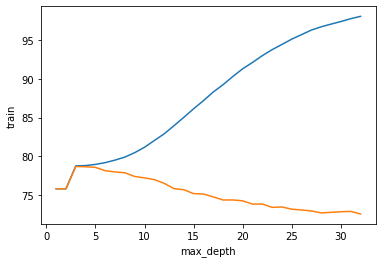

In [ ]:
import seaborn as sns

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)

Como a versão padrão do seaborn no Google Colab é antiga e não possui o lineplot(), será necessário, no início da execução, instalarmos a versão 0.9.0, que contém essa função.

In [ ]:
!pip install seaborn==0.9.0

     |████████████████████████████████| 215kB 5.6MB/s 
  Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


Nele, podemos analisar que conforme aumentamos o max_depth, a média do treino vai ficando cada vez melhor, chegando a quase 100%. Porém, em determinado momento, o algoritmo começa a ficar tão exato para o modelo que deixa de ser adequado para os testes, com a média sendo cada vez menor.

Esse tipo de cenário é chamado de overfitting.

Antes de prosseguirmos, vamos adicionar legendas no gráfico para que ele fique ainda mais legível. Para isso, importaremos matplotlib.pyplot as plt e usaremos plt.legend() para passar nossas legendas Treino e Teste.



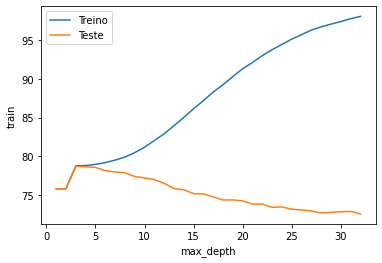

In [ ]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

Agora que varremos todo esse espaço de possibilidades, podemos ordenar os resultados a partir da qualidade do teste (resultados.sort_values("test")) de maneira decrescente (ascending=False), utilizando .head() para mostrar somente os cinco primeiros.

In [ ]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


Podemos perceber as melhores árvores tiveram max_depth = 3, max_depth = 4 ou max_depth = 5. Portanto, usaríamos, por exemplo, max_depth = 3.

Veremos mais variações de parâmetros e como tomar essa decisão nas próximas aulas. Até o momento, devemos entender max_depth é um exemplo de parâmetro de um algoritmo como a árvore decisão. Além disso, é perigoso varrermos demais os dados do treino e, consequentemente, prejudicarmos os resultados do teste.



**Nessa aula aprendemos a:**

*  Definir sobre max_depth;
*  Definir sobre a árvore de decisão ( DecisionTreeClassifier);
*  Mostrar gráficos com o seaborn;
*  Mostrar gráficos com matplotlib;
*  Definir hiperparâmetros.


#Explorando 2 dimensões de hiperparâmetro

**Espaço de parametros de duas dimensões**

Anteriormente, aprendemos que é possível explorar o espaço de um parâmetro do nosso classificador, como o max_depth. Se testássemos, por exemplo, 64 valores para esse parâmetro, teríamos alguns problemas e necessidades. Felizmente, esse não é o nosso objetivo nesse instante, e quando for nós encontraremos outras estratégias mais simples.

O importante agora é notar que, como consta na documentação do DecisionTreeClassifier, esse algorítimo possui diversos outros parâmetros - dentre os quais nem todos são hiperparâmetros.

Um hiperparãmetro é um parâmetro que é setado previamente e que define a regra de criação da nossa árvore de decisão, como o próprio max_depth. Outro exemplo seria min_samples_leaf, que é número mínimo de elementos (samples) em uma folha.

As folhas são os últimos nós de uma árvore de decisão, a partir dos quais não ocorrem mais decisões. Um exemplo de uma árvore "perfeita" seria aquela em que todas as suas folhas contivessem somente um elemento - ou seja, na qual cada elemento tivesse uma classificação específica.

Mas não queremos que o número de samples seja muito baixo, pois isso faria com que o nosso algoritmo ficasse muito específico para o treino, não conseguindo generalizar tão bem para os testes. É para isso que serve o hiperparâmetro min_samples_leaf.

Nosso objetivo agora é explorarmos ambos os espaços de parâmetros, max_depth e min_samples_leaf, com diversos valores discretos.

Poderíamos começar testando max_depth = 1 e min_samples_leaf = 1, depois max_depth = 1 e min_samples_leaf = 2, e assim sucessivamente até termos explorado todas as combinações de parâmetros. Isso resulta em 4096 testes (64 possibilidades do primeiro parâmetro multiplicadas por 64 possibilidades do segundo). Se cada um desses testes levasse 5 minutos, levaríamos 341 horas - aproximadamente 14 dias rodando o algoritmo. Complicado, não? E se tivéssemos ainda mais parâmetros - por exemplo, 10?



**Explorando hiper parâmetros**

Dessa vez, ao invés de rodarmos nossa árvore de decisão para um único parâmetro, a rodaremos para dois. Para isso, criaremos uma cópia do código de roda_arvore_de_decisao(), dessa vez passando max_depth e min_samples_leaf.

Em DecisionTreeClassifier(), adicionaremos o trecho min_samples_leaf = min_samples_leaf para passarmos o parâmetro para nosso modelo. Também precisamos incluir min_samples_leaf = %d na função print(), e min_samples_leaf na tabela e no resultado das nossas colunas.

Como queremos rodar dois valores por vez, não usaremos list comprehension, pois os resultados não seriam tão facilmente legíveis. Vamos começar passando resultados = [] e, depois, criaremos um for max_depth in range(1,33) que culmina em for min_samples_leaf in range(1,33).

Em seguida, tabela deve receber a função roda_arvore_de_decisao com max_depth e min_samples_leaf. Essa tabela será adicionada nos resultados com resultados.append(tabela).

Como esse código está muito solto, vamos agrupá-lo em uma função busca() que devolve resultados. Por mim, definiremos resultados = busca() e chamaremos busca.head() para imprimir os cinco primeiro elementos desses resultados.

In [26]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in range(1,33):
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 3, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 4, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 5, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 6, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 7, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 8, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 9, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 10, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 11, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 12, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 13, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_

,max_depth,min_samples_leaf,train,test
0,1,1,75.791169,75.784219
1,1,2,75.791169,75.784219
2,1,3,75.791169,75.784219
3,1,4,75.791169,75.784219
4,1,5,75.791169,75.784219


Rodar esse código todo vai levar muito tempo. Como não queremos isso, ao invés de testarmos todo o espaço do parâmetro min_samples_leaf, rodaremos apenas uma lista com alguns valores:



In [27]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()


Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


Dessa forma, teremos apenas 128 pares de hiperparâmetros testados. Para analisarmos os resultados, vamos imprimir na tela a tabela dos melhores resultados:

resultados.sort_values("test", ascending=False).head()

In [28]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


Pelo que podemos perceber, os cinco melhores atingiram aproximadamente 78% no teste, todos com max_depth = 4. Já o min_samples_leaf parece não ter influenciado o resultado quando max_depth = 4.



Agora que temos dois hiperparâmetros e estamos em um espaço de duas dimensões, vamos explorar ainda mais esses dados.



**Matriz de correlação e explorando mais e mais espaços de parâmetros**

Neste momento, temos uma tabela que indica a situação de dois parâmetros e quão bem um modelo foi no treino e no teste. Nossa dúvida é: como estão se comportando os resultados de treino e de teste em função dos valores de cada parâmetro?

max_depth	min_samples_leaf	train	test
4	256	78.750993	78.672633
4	32	78.750993	78.672633
4	128	78.750993	78.672633
4	64	78.750993	78.672633
3	32	78.750993	78.672633
Existe uma dificuldade de apreendermos exatamente o que está acontecendo nesses dados: primeiro, porque a tabela é enorme e estamos mostrando apenas os cinco melhores resultados; e também porque estamos omitindo diversos valores possíveis do nosso teste. Será que o resultado seria melhor se tivéssemos escolhido, por exemplo, min_samples_leaf = 57? E min_samples_leaf = 300?

Testar todas as possibilidades consome muito processamento. Uma das abordagens possíveis - claramente a mais complexa -, seria paralelizar esse processamento, distribuindo-o em várias máquinas.

Outra maneira de tentarmos visualizar se existem espaços de parâmetros melhores para o nosso algoritmo é procurarmos uma relação entre o resultado de teste e esses parâmetros por meio de uma análise de correlação. O próprio Pandas nos disponibiliza esse tipo de análise estatística tradicional, bastando escrevermos resultados.corr().

max_depth	min_samples_leaf	train	test
max_depth	1.000000	0.000000	0.681408	-0.522835
min_samples_leaf	0.000000	1.000000	-0.453825	0.528330
train	0.681408	-0.453825	1.000000	-0.762534
test	-0.522835	0.528330	-0.762534	1.000000
Quanto mais alto o valor, mais correlacionados estão os elementos na comparação. Por exemplo, quanto maior o max_depth, maior será o max_depth. Essa é uma conclusão bastante óbvia, afinal o max_depth é ele mesmo, mas que nos ajuda a entender o que está acontecendo. Além disso, repare resultados positivos (maiores que 0) representam uma correlação positiva, e negativos uma correlação negativa.

Outras conclusões que podemos tirar a partir desses resultados:

quando max_depth cresce, o treino parece crescer também
quando min_samples_leaf cresce, o treino cai
quando max_depth sobe, o teste cai
quando min_samples_leaf sobe, o teste sobe
Note que essa não é uma prova de causalidade, mas um teste de correlação.

Uma técnica comum para visualizarmos essa correlação é plotar esses resultados em um gráfico. Primeiramente, atribuiremos essa correlação a uma variável corr. Em seguida, com o seaborn, impriremos a correlação em um mapa de calor (sns.heatmap(corr)).

mapa de calor correlacionando `max_depth`, `min_samples_leaf`, `train` e `test` 

No nosso exemplo, os espaços mais próximos da cor vinho têm uma correlação muito alta, como fica claro nos quadrados da diagonal. Em contrapartida, quanto mais próximos do azul marinho, menor é essa correlação.



In [29]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000,0.000000,0.536705,-0.027675
min_samples_leaf,0.000000,1.000000,-0.409676,0.349011
train,0.536705,-0.409676,1.000000,0.116466
test,-0.027675,0.349011,0.116466,1.000000


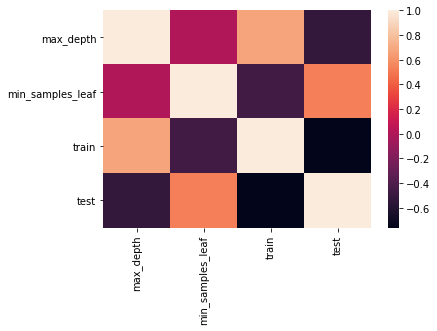

In [ ]:
sns.heatmap(corr)

Existem outras maneiras de visualizarmos essa correlação. Dessa vez, usaremos outro tipo de comparação desses valores: uma matriz que mostra os pontos soltos (scatter_matrix()).

Nela, passaremos os resultados, acompanhados de figsize = (14, 8) (para que os gráficos fiquem um pouco maiores e mais fáceis de serem analisados) e alpha = 0.3 (para ajustarmos a transparência dos pontos plotados).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcaec1e62e8>,
      dtype=object)

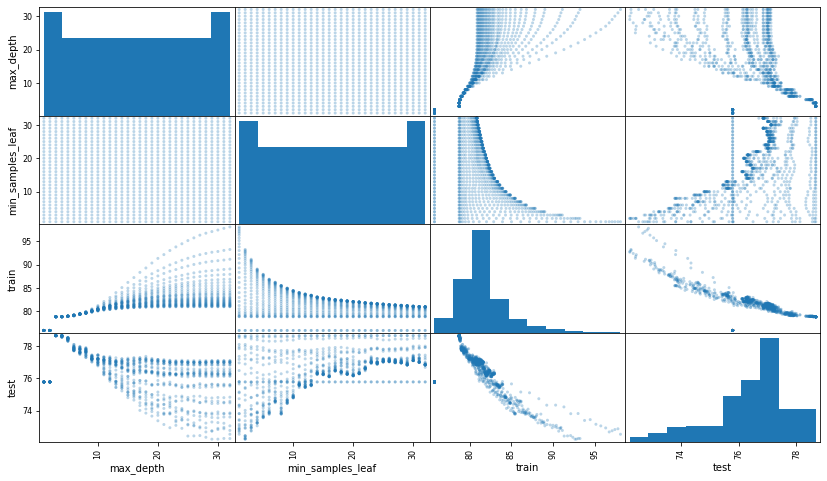

In [ ]:

from pandas.plotting import scatter_matrix

scatter_matrix(resultados, figsize = (14, 8), alpha = 0.3)

Na diagonal, são exibidos os histogramas dos valores. Por exemplo, para train, tivemos diversos resultados na faixa de 79%, e no test tivemos diversos valores na faixa de 78%.

Já os gráficos que não compõem a diagonal são equivalentes à nossa correlação - à medida em que max_depth aumenta, o resultado de test cai e o resultado de train sobe, entre outras correlações.

Outra visualização possível no Seaborn é o pairplot(), que plota os resultados pareados, de maneira muito parecida com nossa scatter_matrix.

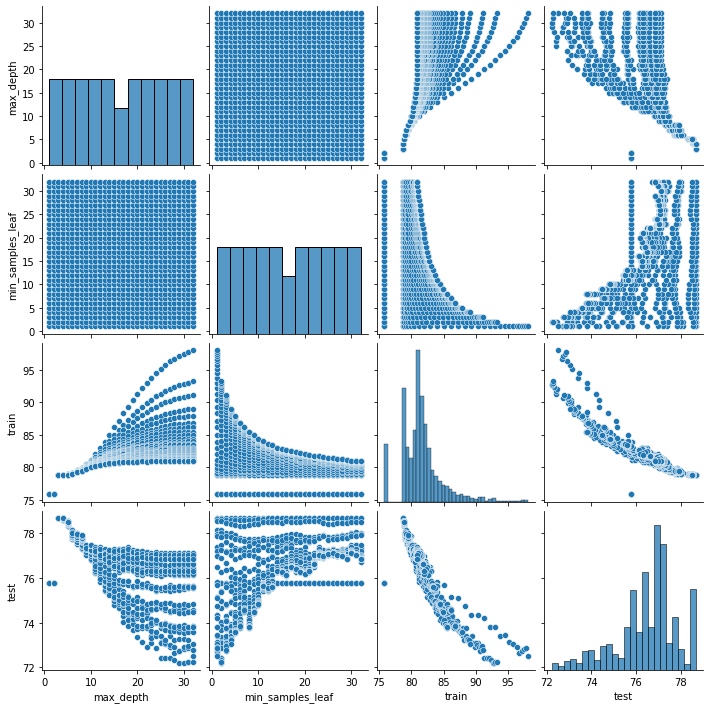

In [ ]:
sns.pairplot(resultados)

Na diagonal, teremos novamente os histogramas dos valores. Os outros gráficos fazem os relacionamentos de um parâmetro em função do outro, e novamente podemos analisar que, enquanto max_depth aumenta, o test cai.

No gráfico do canto inferior esquerdo, temos 4 linhas que provavelmente representam cada valor de min_samples_leaf. Entretanto, ao menos nesse gráfico, é impossível visualizarmos qual valor cada linha representa.

Por último, geraremos outro gráfico que consta na própria documentação do seaborn correlations, a matriz de correlação diagonal (diagonal correlation matrix). Para isso, copiaremos o código que consta nessa documentação, apenas removendo os trechos em que os dados são gerados e atribuídos à uma variável corr.

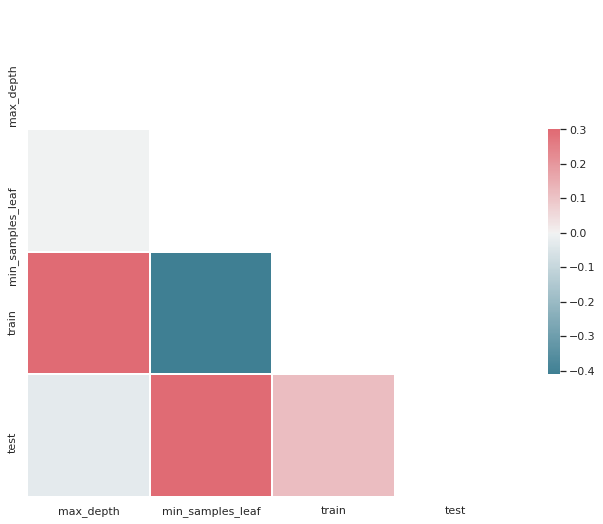

In [30]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Repare que somente os dados que nos interessam (ou seja, aqueles que não são equivalentes) são plotados com cores na matriz. Nela, percebemos que parece existir uma correlação muito forte entre test e min_samples_leaf - quanto maior o min_samples_leaf, maior a qualidade do test.

Com esses dados em mãos, podemos então testar outros valores. Como obtivemos resultados melhores com 128 e 256, vamos mantê-los, adicionando 192 e 512.

In [31]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf","train","test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


Isso não garante que iremos encontrar o melhor valor possível para o nosso parâmetro, mas é uma maneira de explorarmos as possibilidades e resultados.

Após executarmos esse código, vamos rodar novamente corr = resultados.corr() e o código que gera a nossa matriz.



Dessa vez, o resultado é uma correlação negativa entre min_samples_leaf e test.

Com resultados.sort_values("test", ascending=False).head(), analisaremos outra vez quais foram os cinco melhores resultados desse teste:

Essa é uma maneira de tentarmos encontrar os valores que mais otimizam o nosso estimador, com o menor índice de erro e o maior nível de qualidade. Fizemos isso com dois parâmetros, mas é possível trabalhar com um número ainda maior!

Nessa aula aprendemos a:

*   Definir os elementos mínimos em uma árvore de decisão;
*   Utilizar o min_samples_leaf para treino;
*   O que é corr do pandas;


#Trabalhando com 3 ou mais dimensões

**Explorando 3 ou mais parâmetros**

Nas aulas anteriores, exploramos um espaço de 2 dimensões, atrelado a 2 parâmetros. Mesmo assim, não exploramos todo o espaço de parâmetros, e mesmo que tenhamos encontrado valores que parecem razoáveis, não temos garantia de que são os melhores possíveis.

Na documentação do DecisionTreeClassifier, encontramos diversos outros parâmetros - e vários deles são hiperparâmetros.

Dessa vez, vamos trabalharemos com min_samples_split. Antes, estávamos explorando o mínimo de samples em um nó final (a nossa "folha"), e agora exploraremos o mínimo de "quebras" (splits) que podemos ter no meio da árvore.

Para isso, na nossa função busca(), precisaremos criar mais um for, novamente com valores fixos - nesse caso, 32, 64, 128 e 256. Além disso, min_samples_split deve ser adicionado:

como parâmetro da função roda_arvore_de_decisao()
como parâmetro de DecisionTreeClassifier().
como um dos valores de tabela
como uma das colunas de DataFrame()

In [ ]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test
0,1,32,32,75.791169,75.784219
1,1,32,64,75.791169,75.784219
2,1,32,128,75.791169,75.784219
3,1,32,256,75.791169,75.784219
4,1,64,32,75.791169,75.784219


Repare que removemos o trecho no qual os resultados eram imprimidos na tela. Isso porque, além de aumentar o tempo de execução do nosso código - que já é 4 vezes maior que quando tínhamos apenas 2 parâmetros -, a lista de resultados não nos trazia nenhuma informação relevante, já que era praticamente ilegível, servindo apenas para acompanharmos o debug.

O resultado na tela é a seguinte tabela:

max_depth	min_samples_leaf	min_samples_split	train	test
1	32	32	75.791169	75.784219
1	32	64	75.791169	75.784219
1	32	128	75.791169	75.784219
1	32	256	75.791169	75.784219
1	64	32	75.791169	75.784219


Em seguida, assim como fizemos anteriormente, vamos analisar a correlação e imprimir o gráfico de matriz de correlação diagonal.



Com base nesse gráfico e na análise dos 5 melhores resultados do teste, poderíamos tomar uma decisão entre continuar explorando esse espaço de parâmetros ou não.

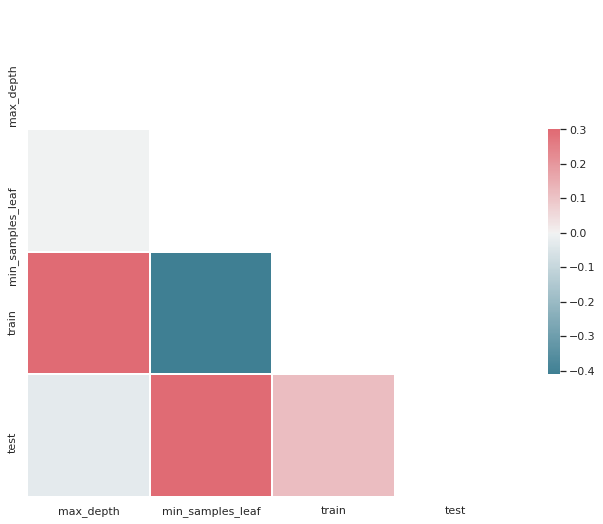

In [32]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Outro fator que pode ser analisado é o tempo que a máquina virtual leva para treinar o algoritmo. O próprio cross_validate() tem, entre os seus resultados, a cronometragem do tempo. Portanto, basta extrairmos as variáveis referentes ao tempo e imprimirmos na tabela.

Usaremos fit_time = results['fit_time'].mean() e score_time = results['score_time'].mean() para extrairmos a média de tempo do treino e do teste. Também precisaremos passar fit_time e score_time como parâmetros de tabela e como colunas de DataFrame().

Rodando esse código, iremos testar 512 combinações diferentes de hiperparâmetros no nosso cross_validate(), que são 10 tentativas de treino e teste. Portanto, são 5120 splits de treino/teste no nosso modelo, e por isso a execução demora algum tempo.

Após a execução, geraremos novamente a tabela com os 5 melhores resultados e o gráfico plotando a correlação dos dados:

In [ ]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.006196,0.001475
1,1,32,64,75.791169,75.784219,0.005581,0.001273
2,1,32,128,75.791169,75.784219,0.005445,0.001252
3,1,32,256,75.791169,75.784219,0.005425,0.001256
4,1,64,32,75.791169,75.784219,0.005356,0.001235


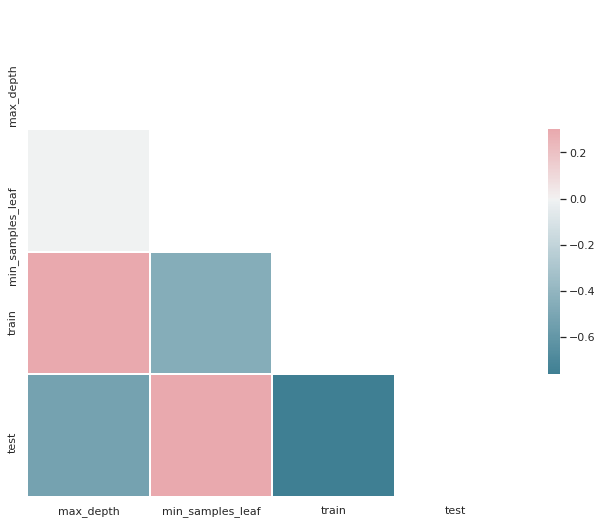

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Com base nesse gráfico e na análise dos 5 melhores resultados do teste, poderíamos tomar uma decisão entre continuar explorando esse espaço de parâmetros ou não.

Outro fator que pode ser analisado é o tempo que a máquina virtual leva para treinar o algoritmo. O próprio cross_validate() tem, entre os seus resultados, a cronometragem do tempo. Portanto, basta extrairmos as variáveis referentes ao tempo e imprimirmos na tabela.

Usaremos fit_time = results['fit_time'].mean() e score_time = results['score_time'].mean() para extrairmos a média de tempo do treino e do teste. Também precisaremos passar fit_time e score_time como parâmetros de tabela e como colunas de DataFrame().

Rodando esse código, iremos testar 512 combinações diferentes de hiperparâmetros no nosso cross_validate(), que são 10 tentativas de treino e teste. Portanto, são 5120 splits de treino/teste no nosso modelo, e por isso a execução demora algum tempo.

Após a execução, geraremos novamente a tabela com os 5 melhores resultados e o gráfico plotando a correlação dos dados:

In [ ]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.006232,0.001494
1,1,32,64,75.791169,75.784219,0.005588,0.001277
2,1,32,128,75.791169,75.784219,0.005557,0.001217
3,1,32,256,75.791169,75.784219,0.005610,0.001340
4,1,64,32,75.791169,75.784219,0.005721,0.001339


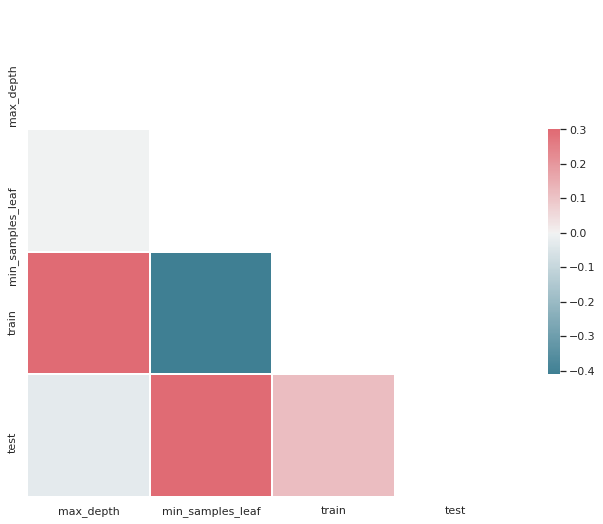

In [33]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Repare que existe uma pequena diferença entre os tempos de treino e os treinos de teste. Nesse caso, nosso treino é tão rápido que essas diferenças são insignificantes. Porém, se tivéssemos um algoritmo que demora 30 minutos para fazer o treinamento e no qual o tempo de teste fosse muito alto, talvez valesse a pena escolhermos os valores com base nesses resultados.

Além dos 3 parâmetros que analisamos até agora, o DecisionTreeClassifier possui vários outros, a exemplo do critério de análise da árvore (como e/ou quando quebrar). Esse parâmetro pode receber dois diferentes valores, como gini ou entropy.

Os parâmetros de um algoritmo estimador não precisam ser discretos como os que estudados até o momento. Por exemplo, existem casos em que trabalhamos com escala logarítmica ou exponencial, e é mais interessante explorar valores mais altos ou mais baixos. Ou seja, existem vários tipos de espaços de parâmetros que podem ser explorados.

Agora que aprendemos a trabalhar com 3 parâmetros, lembre-se que é possível utilizar 4, 5 ou dezenas de parâmetros diferentes. Na prática, não há como explorar todas as possibilidades, portanto a ideia é explorarmos somente uma seleção delas - assim como estamos fazendo nesse curso. Com todo o esforço que isso demanda, seria ideal se tivéssemos uma biblioteca que já fizesse esse processo de otimização do nosso modelo.

Felizmente, o SKLearn tem uma maneira de buscar a otimização de parâmetros em um grid., e aprenderemos mais sobre ela a seguir.



Nessa aula aprendemos a:

* Utilizar mais do que um hiperparâmetro
* Gerar um gráfico com matplotlib;
* O que é min_samples_split;

#Busca de parâmetros com o GridSearch

Agora que já aprendemos a importância de uma busca em grid pelos parâmetros que maximizam a métrica que estamos utilizando no nosso sistema, queremos utilizar uma ferramenta que nos ajude nesse processo.

O próprio SKLearn possui o GridSearchCV (grid search cross validation), que faz justamente essa busca de hiperparâmetros com validação cruzada.

Para isso, importaremos o GridSearchCV do sklearn.model_selection. Em seguida, determinaremos o SEED como 301 (mantendo o mesmo seed padrão) e definiremos o nosso espaco_de_parametros.

Ele deve conter diversas dimensões:

max_depth com os valores 3 e 5
min_samples_split com os valores 32, 64 e 128
min_samples_leaf também com os valores 32, 64 e 128
criterion com os valores gini e entropy (que são strings)
Ou seja, estaremos explorando 4 dimensões diferentes que resultam em 36 combinações. Nossa busca será um GridSearchCV(), passando DecisionTreeClassifier(), espaco_de_parametros e o cross validation com 10 splits (cv = GroupKFold(n_split = 10)).

O GridSearchCV() vai funcionar como um modelo. Portanto, podemos fazer busca.fit(), que irá rodar o cross validation dentro dele. Portanto, passaremos os parâmetros x_azar e y_azar, e os grupos (groups = dados.modelo).

Depois da busca, passaremos para o nosso pd.DataFrame() o cv_results_, um dicionário do GridSearchCV que pode ser importado em dataframe do Pandas. Por mim, escreveremos resultados.head() para recebermos os 5 melhores resultados.

In [37]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011177,0.000923,0.001671,0.000083,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.010962,0.000355,0.001697,0.000059,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.011089,0.000919,0.001730,0.000329,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.011334,0.000368,0.001812,0.000220,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.010951,0.000483,0.001636,0.000140,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


Essa tabela nos mostra diversas informações, como a média do tempo de treino, a média do tempo de teste, a acurácia do teste e do treino e o ranking delas, quais foram cada um dos parâmetros utilizados, entre outras.

Com busca.best_params_, podemos imprimir na tela os melhores parâmetros; e com busca.best_score_ * 100, o melhor resultado em porcentagem:



In [38]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


Se quisermos o melhor estimador em si, podemos pegá-lo com busca.best_estimator_:

In [39]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Se quiséssemos, também poderíamos rodar a correlação e montar um gráfico em cima desses dados.

Dado esse resultado, quão bem ele se sairia no mundo real? No curso anterior, aprendemos que, depois que treinamos o estimador com cross validation, podemos rodar um fit para obtermos o modelo que utilizaremos no mundo real. Como já temos esse modelo, podemos tentar predizer a sua acurácia com melhor.predict(x_azar), que atribuiremos a uma variável predicoes.

Em seguida, criaremos uma variável accuracy recebendo accuracy_score(predicoes, y_azar) * 100. Lembre-se de importar essa função de sklearn.metrics, do contrário ela não funcionará.

In [40]:
from sklearn.metrics import accuracy_score 

predicoes = melhor.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


O console nos retornará:

Accuracy para os dados foi 78.75%

Mas será que esse é mesmo o resultado que esperamos no mundo real?



O que aprendemos nesta aula:

* Utilizar o GridSearchCV;
* Utilizar o accuracy_score.


#Nested cross validation e validando o mlehor modelo

Utilizamos o GridSearchCV do SKLearn para encontrarmos o melhor conjunto de hiperparâmetros em um espaço definido, de modo a otimizar a nossa métrica (accuracy). Quando tentamos analisar quão bem nosso algoritmo se sairia no mundo real, pegamos o melhor conjunto (representado por melhor) e utilizamos um predict() em cima de x_azar - ou seja, com todos os dados e uma única vez. Porém, durante o nosso processo de aprendizado, utilizamos o cross validation, e existem alguns cuidados que devemos tomar a esse respeito.

Na documentação do SKLearn, encontramos uma seção sobre nested versus non-nested cross-validation. O texto afirma que quando estamos utilizando hiperparâmetros, fazendo, por exemplo, o GridSearchCV junto com o cross_validation_score, não devemos descobrir a nossa métrica por meio do predict() pois estariamos sendo otimista (viciada nos dados que eu já vi) e queremos uma mais realista, mas sim com outro cross_valiation_score.

Utilizar o predict() acaba sendo muito otimista, pois acabamos incorrendo em um vício sobre os dados que já tínhamos visto. Portanto, essa abordagem deve ser evitada.

No nosso novo teste, importaremos cross_val_score de sklearn.model_selection. Em seguida, chamaremos cross_val_score(), passando busca, x_azar e y_azar. O cross validation será o mesmo que estávamos utilizando anteriormente (GroupKFold(n_splits=10), e os grupos serão dados.modelo.

Esse código nos retornará vários scores.



**como ter uma estimativa sem esse vício nos dados que já eu vi?**

In [41]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The 'groups' parameter should not be None.

  FitFailedWarning)


Tentando rodar esse código, receberemos um erro afirmando que o valor de groups não deve ser none, como se não tivéssemos passado nenhum valor para os grupos. Ou seja, de alguma forma groups não está chegando em GroupKFold() - e é exatamente isso que está acontecendo.

Na verdade, isso ocorre por conta de um bug - o GroupKFold falha na validação cruzada aninhada, e existe até um tópico no GitHub do scikit sobre esse problema. É um bug antigo (o tópico foi criado em 2016), mas continua em aberto, pois é razoavelmente complicado implementar a correção dele.

**Como o Pandas não suporta nested validation com o GroupKFold, não conseguiremos prever o resultado para novos grupos. Como alternativa, usaremos o KFold comum, que precisa ser importado de sklearn.model_selection.**

Além disso, mudaremos o número de splits para 5, adicionaremos o parâmetro shuffle=True e removeremos o parâmetro groups de busca.fit().

Como estamos rodando com KFold normal, essa estimativa é feita sem saber se o grupo é novo ou não.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011446,0.002362,0.001710,0.000133,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.009579,0.000370,0.001620,0.000160,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.009645,0.000317,0.001578,0.000171,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.009479,0.000137,0.001573,0.000173,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.010311,0.001112,0.001784,0.000426,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


Agora podemos rodar o cross_val_score() como gostaríamos, passando KFold(n_splits=5, shuffle=True) no cross validation.

In [46]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

Nossos resultados serão esses cinco valores:

array([0.782 , 0.791 , 0.8075, 0.777 , 0.777 ])

Com eles, é possível reconstruir a média e o intervalo. Para isso, criaremos uma função imprime_scores() que recebe scores. Na media, usaremos scores.mean() * 100, e no desvio scores.std() * 100.

In [47]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Em seguida, basta chamarmos a função imprime_score(scores). O resultado será:



In [48]:
imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [49]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Agora vamos imprimir a árvore de decisão que encontramos como nosso melhor estimador:



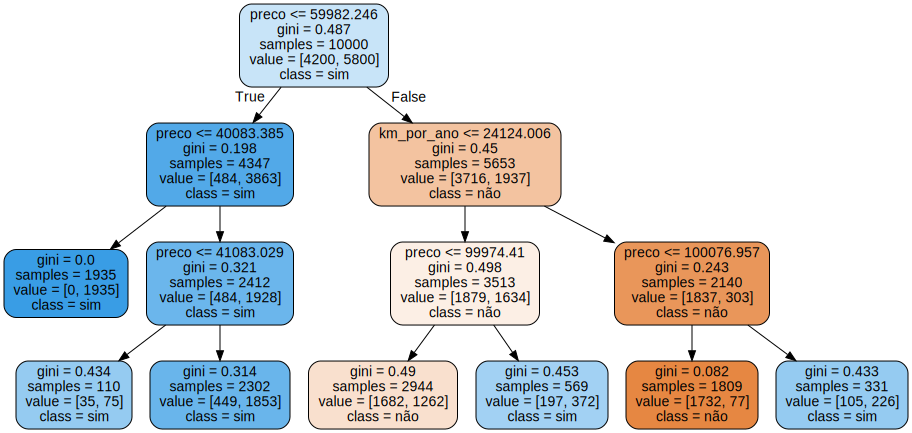

In [ ]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph

Repare que a árvore tem 3 níveis de profundidade (max_depth=3, ou seja, três decisões a serem tomadas), e as folhas e os splits (min_samples_leaf e min_samples_split, respectivamente) têm um mínimo de 32 samples cada. Além disso, as decisões de quebras seguem o critério de gini ao invés de entropy.

Esse é o melhor modelo real que iremos utilizar agora que exploramos o espaço de hiperparâmetros. Esse tipo de exploração com grid, no qual cada espaço é analisado separadamente, é válido e funciona. Porém, é um processo demorado, e existem otimizações que podem ser feitas para contornar isso.



Com isso, terminamos nosso primeiro processo exploratório de otimização dos nossos modelos. Repare que o SKLearn dá um nome muito interessante para esse processo de validação e otimização de hiperparâmetros: model selection.

Para selecionarmos o melhor estimador, dependemos da validação cruzada e dos hiperparâmetros - ou seja, de buscar os parâmetros ideias para o modelo, seja por meio do GridSearchCV, seja por outras estratégias.

Nós começamos com um modelo de árvore de decisão que tinha uma profundidade específica, e que comparamos com o DummyClassifier. Então começamos a testar diferentes profundidades, percebendo que ela é uma característica importante do nosso estimador - mais especificamente, um hiperparâmetro.

Cada estimador (DecisionTreeClassifier, SVC, RandomForest, etc.) possui seus próprios hiperparâmetros a serem otimizados. Além disso, cada hiperparâmetro possui determinadas regras - alguns são contínuos, outros binários, entre outros tipos de valores que podem ser explorados.

Para entendermos o funcionamento desse processo de otimização, exploramos os hiperparâmetros manualmente. Com isso fixado, também utilizamos o GridSearchCV *para facilitar o processo, aprendendo as limitações dessa biblioteca do SKLearn - mais especificamente, a validação cruzada de grupos, que incorre em um *bug na execução (que em algum momento deve ser corrigido).

Como não conseguimos prever a capacidade do nosso modelo de se adaptar a novos grupos, tivemos que treiná-lo de maneira independente dos grupos - no caso, utilizando o KFold, mas existem outras variações de KFold e de estratégias de busca no espaço de hiperparâmetros ou de otimização.

Em uma segunda parte desse curso de otimização de parâmetros, aprenderemos a utilizar essas outras estratégias de busca, como a busca aleatória. Esperamos que você tenha gostado e possa colocar tudo o que você aprendeu em prática!

Não deixe de nos enviar um feedback, pois sua opinião é muito importante para melhorarmos cada vez mais a plataforma. Bons estudos e até a próxima!

O que aprendemos nesta aula:

* O que é nested cross validation;
* Importar o GroupKFold;
* Visualizar o melhor estimador.

# Curso Machine Learning parte 2: Otimização com exploração aleatória

#Módulo 1 - Randomized SEarch e Cross Validation

No curso anterior sobre otimização de estimadores por meio de hiperparâmetros, estávamos, em um grid, discretizando o espaço de hiperparâmetros e buscando, de maneira exaustiva, os melhores resultados.

Por exemplo: quando nosso estimador tinha duas dimensões (max_depth e min_samples_leaf), nós testávamos diversos valores diferentes em sequência, abordando todo aquele espaço de parâmetros no grid.

Feito isso, decidíamos explorar de maneira mais refinada determinados espaços... e assim sucessivamente. Porém, esse processo consome muito tempo e processamento computacional, o que certamente resultaria em custos financeiros.

Se tínhamos esse problema com duas dimnesões, imagine se tivésses três dimensões, ou quatro... ou uma quantidade ainda maior de parâmetros?O número de combinações gerado seria gigantesco, e levaria muito tempo para chegarmos a um resultado.

Existem outras maneiras de buscarmos a melhor otimização para nossos estimadores. Por exemplo, ao invés de explorarmos exaustivamente o espaço de parâmetros (ou um subespaço discretizado), colocaremos nossos hiperparâmetros em um grid (não necessariamente de maneira discreta, mas também de maneira contínua), e testaremos valores aleatórios.

A ideia é que não existe a necessidade de explorar todo o espaço de parâmetros para encontrar pontos de mínimo ou de máximo que sejam bons o suficiente para o problema que estivermos tentando resolver - não necessariamente o mínimo global ou o máximo global, mas valores que sejam suficientemente adequados para a situação problema.

Ou seja, enquanto a busca no grid (grid search) vai varrer todas as possibilidades e demora muito tempo, apesar de ser possível rodá-lo de maneira paralela, a busca aleatória (random search) vai rodar em menos tempo e permite outras otimizações, pois não iremos explorar exaustivamente todos os valores possíveis do nosso espaço de hiperparâmetros.

Nesse curso, aprenderemos como implementar uma busca aleatória e como preparar as soluções a partir disso. Assim como no curso anterior, na maior parte do processo trabalharemos com a validação cruzada.

Porém, em determinado ponto, também abordaremos, com o auxílio do train_test_split, a otimização de hiperparâmetros sem validação cruzada, mantendo as fases de treino, teste e validação.

Dessa forma, você terá as duas opções para utilizar no seu dia-a-dia. Vamos começar?

**Explorando aleatoriamente**

Já aprendemos que, quando temos um espaço de parâmetros com duas dimensões, podemos explorá-lo ponto a ponto. Isto é, transformamos espaços contínuos em espaços discretos e exploramos, nesses pontos, o nosso algorítimo.

Por exemplo, se estamos trabalhando com um algorítimo de DecisionTreeClassifier que tem os parâmetros max_depth e min_samples_leaf, podemos testar cada um desses parâmetros com um valor específico. Depois de medirmos o resultado, repetimos o processo para o próximo parâmetro.

Dessa forma, exploramos o espaço até completarmos o grid todo. Por exemplo, se temos 15 condições para cada parâmetro, rodamos o algorítimo 225 vezes para explorar esse espaço por completo.

Mas e quando temos 3 parâmetros, cada um com uma determinada quantidade de condições? Nesse caso, ainda poderíamos plotar esses dados em um gráfico 3D... mas e se tivéssemos 4 parâmetros ou mais?

Supondo que tivéssemos 3 parâmetros com 64 condições cada um, e um parâmetro com apenas 2 condições. Nessa situação, teríamos que explorar 524.288 possibilidades de parâmetros. Se cada uma dessas explorações levasse 5 minutos (o que é um exemplo razoável), seriam necessários 1820 dias para testar todas essas possibilidades. Se estivéssemos rodando esse algorítimo em 5 máquinas, ainda assim levaríamos 1 ano para terminar o processo.

Vamos analisar o grid de duas dimensões abaixo:


Mesmo que não haja garantia disso, esperamos que os valores representados no grid tenham resultados próximos aos seus vizinhos. Ou seja, pode não existir uma mudança brusca entre pontos muito próximos do nosso espaço discretizado de parâmetros.

Com isso em mente, ao invés de tentarmos explorar todo o grid (o que é feito no grid search), poderíamos buscar pontos aleatoriamente (random search). E é exatamente isso que faremos agora.

Começaremos essa busca aleatória ao final do projeto no qual trabalhamos no curso anterior. Se você não fez o curso, pode fazer o download do projeto neste link ou visualizar os arquivos no GitHub.

Para organizarmos nosso trabalho, adicionaremos uma célula de texto indicando onde se inicia o RandomSearch. Esse processo de busca é bastante parecido com tudo o que fizemos anteriormente, e também se inicia definindo um espaço de parâmetros a ser explorado.

Portanto, começaremos copiando o código que criamos para GridSearchCV:

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011043,0.002134,0.001596,0.000041,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.009460,0.000173,0.001496,0.000031,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.009424,0.000095,0.001502,0.000021,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.009502,0.000139,0.001541,0.000082,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.009676,0.000335,0.001527,0.000044,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


Em seguida, alteraremos os campos em que GridSearchCV aparece para RandomizedSearchCV. Manteremos a mesma SEED e o mesmo espaço de parâmetros (com 36 possibilidades). Quando trabalhos com processos aleatórios, é muito comum que o modelo contenha um parâmetro random_state para manter a consistência entre todas as execuções. No caso, esse parâmetro receberá nosso SEED como valor.

Dentre essas 36 possibilidades de combinações de parâmetros, quantas queremos rodar? Se executarmos todas, estaremos fazendo exatamente a mesma busca que com o GridSearchCV, alterando apenas a ordem. Ou seja, devemos executar somente algumas.

Um dos parâmetros que RandomizedSearchCV pode receber é o número de iterações - n_iter. A ideia é, nesse momento, rodarmos apenas 16 dessas possibilidades:

In [54]:
from sklearn.model_selection import RandomizedSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5),
                          random_state = SEED)


busca.fit(x_azar, y_azar,groups = dados.modelo)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013798,0.001276,0.001687,0.000111,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.4330,0.4525,0.771,0.742,0.7725,0.6342,0.156817,1
1,0.009354,0.000135,0.001669,0.000330,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
2,0.009345,0.000204,0.001497,0.000048,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4015,0.4165,0.771,0.766,0.7725,0.6255,0.176848,11
3,0.019505,0.000936,0.001645,0.000089,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5
4,0.019288,0.000470,0.001566,0.000019,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.4240,0.4535,0.771,0.750,0.7445,0.6286,0.155544,5


Após a execução desse código, queremos saber quão bem se saiu o melhor classificador. Da mesma forma que no GridSearchCV, encontraremos uma resposta com cross_val_score() (nested cross validation).

In [55]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7755, 0.78  , 0.8055, 0.7855, 0.774 ])

O resultado na tela será um array de cinco valores:

array([0.7755, 0.78 , 0.8055, 0.7855, 0.774 ])

Também iremos imprimir a acurácia média dessas cinco amostras e o intervalo que obtivemos:

In [56]:
from sklearn.model_selection import cross_val_score 

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)

Accuracy médio 78.69
Intervalo [76.70, 80.68]


Em seguida, para encontrarmos o melhor estimador, atribuiremos a função busca.best_estimator_ à uma variável melhor e imprimiremos essa variável na tela.



In [59]:
melhor = busca.best_estimator_
print(melhor)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=128, min_samples_split=128,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Isso significa que o melhor estimador teve o critério gini, a profundidade máxima 5, o mínimo de elementos na folha 128 e, e 128 como o mínimo de splits antes de tomar uma decisão. Tivemos uma acurácia média de 78.69%, em um intervalo entre 76.70% e 80.68%.

Repare que executando menos da metade das buscas, obtivemos uma acurácia média e um intervalo muito parecidos com aqueles do GridSearchCV (que tinha a média 78.68% e o intervalo 76.85% a 80.55).

Nesse ponto, também podemos gerar a árvore de decisões:

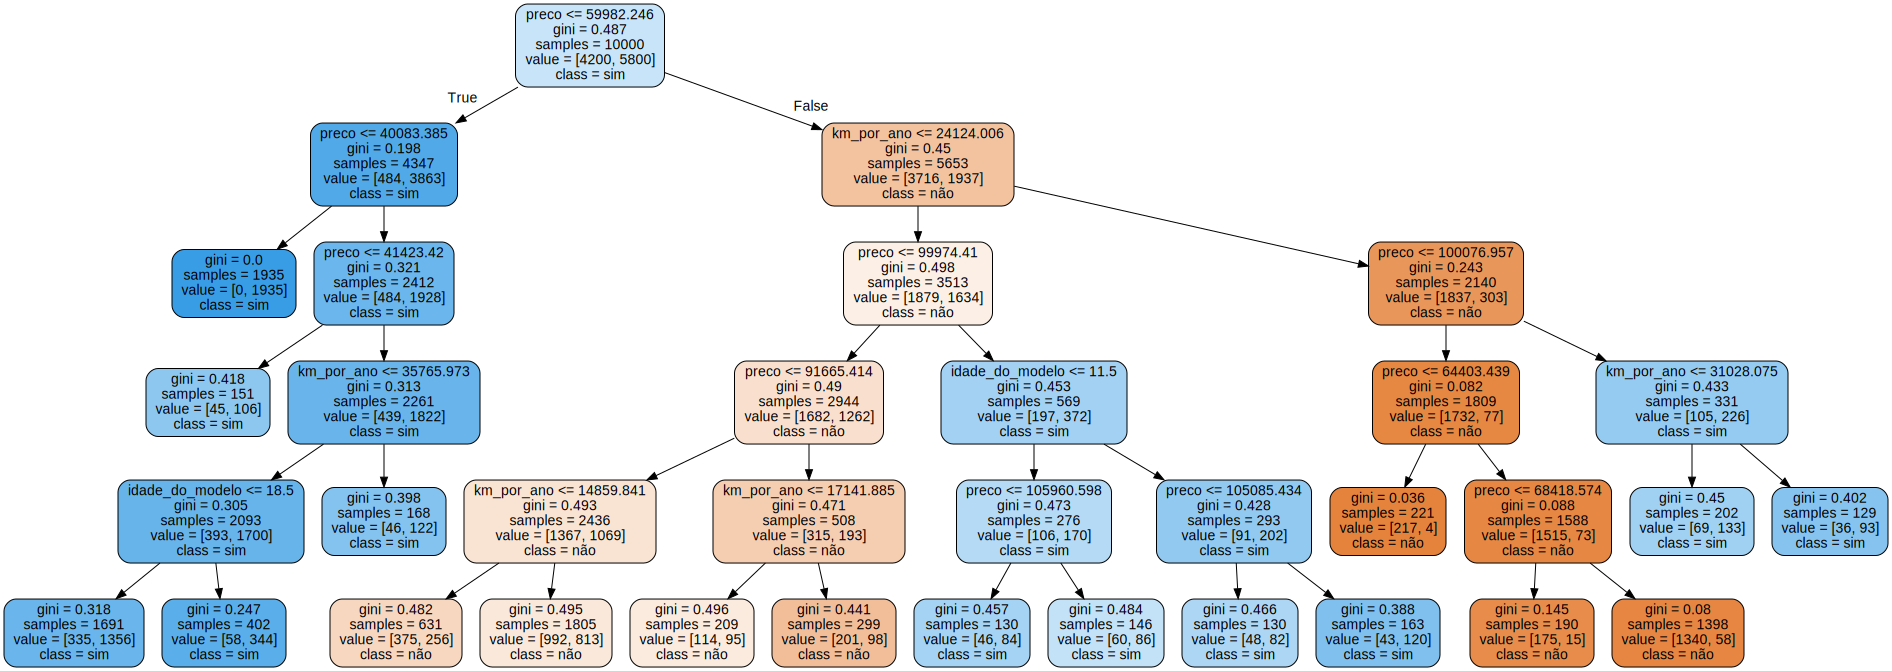

In [60]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                        class_names=["não", "sim"],
                        feature_names = features)

graph = graphviz.Source(dot_data)
graph

Na prática, a utilização do RandomizedSearchCV nos permite encontrar valores muito próximos aos que mais otimizarão nossos estimadores, sem que seja necessário explorar todo o espaço de parâmetros (o que muitas vezes é impossível).

O que aprendemos nesta aula:

* O que é um random search;
* Diferença entre random search e grid search.

## Módulo 2 - Explorando por mais tempo espaços maiores

Nós exploramos aleatoriamente o nosso espaço de parâmetros, mas fizemos isso de maneira bem restrita. Anteriormente, devido às limitações de processamento do GridSearchCV (principalmente em relação ao tempo), nós utilizamos somente 36 combinações.

Porém, seria mais interessante explorarmos ainda mais parâmetros no nosso algorítimo - por exemplo, um max_depth que recebesse 10, 20, 30 ou até que não tivesse limites (o que é possível com None, segundo a documentação do próprio GridSearchCV).

A ideia é executarmos novamente o RandomizedSearchCV, mas com diferentes customizações nesse espaço de parâmetros. Por exemplo, em max_depth, ao invés de termos somente os valores 3 e 5, teremos um conjunto discreto de números inteiros (3, 5, 10, 15, 20, 30) com a adição do valor None.

Em min_samples_split e min_samples_leaf, queremos qualquer número inteiro aleatório entre 32 e 128. Para isso, precisaremos de uma função de aleatoriedade que devolva um número aleatório a cada execução - neste caso, randint (random integer). Essa função deve ser importada do pacote scipy,stats.

Segundo a documentação do SciPy randint, ele percorre desde o número mais baixo (low, no nosso código 32) até o número anterior ao mais alto (high - 1, ou seja, 127).

Isso significa que agora temos muito mais possibilidades de combinações: são 7 elementos para max_depth, 96 para min_samples_split e min_samples_leaf, e 2 para criterion - no total, 129.024 combinações diferentes de parâmetros.

Desse número, executaremos apenas 16, a mesma quantidade que estávamos executando anteriormente, mas com um espaço de parâmetros muito maior e mais complexo:

**customizando o espaço de hiper parametros**

In [61]:
from scipy.stats import randint #pacote de python para ciencia que gera números aleatórios

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128), #qlq numero entre 32 e 128
    "min_samples_leaf" : randint(32, 128), #qlq numero entre 32 e 128
    "criterion" : ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5, shuffle=True),
                          random_state = SEED)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014912,0.001658,0.001711,0.000200,entropy,3,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7840,0.7760,0.8025,0.7930,0.7795,0.7870,0.009618,1
1,0.017144,0.000569,0.001593,0.000031,gini,15,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7740,0.7725,0.7830,0.7805,0.7725,0.7765,0.004393,14
2,0.015747,0.000261,0.001735,0.000192,gini,20,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7705,0.7745,0.7990,0.7790,0.7735,0.7793,0.010221,8
3,0.021400,0.002157,0.001815,0.000308,gini,None,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7575,0.7730,0.7725,0.7835,0.7560,0.7685,0.010378,16
4,0.018494,0.002068,0.002101,0.000442,gini,15,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7705,0.7735,0.7995,0.7790,0.7745,0.7794,0.010413,7


Em seguida, imprimiremos os resultados e o melhor conjunto na tela:

In [62]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.71
Intervalo [77.49, 79.93]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=71, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Nossa acurácia foi bem próxima dos resultados anteriores, mas o ponto é que demoramos um tempo 8.000 vezes menor para explorar esse espaço de parâmetros, obtendo resultados tão bons quanto conseguiríamos com o GridSearchCV.

**Será q vale a pena explorar mais?**

Queremos ordenar os resultados da nossa busca pelo score médio (mean_test_score). Para isso, usaremos o sort_values, passando o nome dessa coluna e o argumento ascending=False (negando a ordenação crescente da função). Nesse momento, não estamos levando em consideração o intervalo de confiança (com duas vezes o desvio padrão).

In [65]:
#no pandas é o sort_values e como quero decrescente o ascending = False
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)

#devolve o indice e a linha atraves iterrows que intera pela linha
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print(indice)

0
6
12
8
13
11
4
2
7
15
14
10
9
1
5
3


Esses são os índices ordenados do maior mean_test_score para o menor. Agora, imprimiremos o mean_test_score, o desvio padrão do teste (std_test_score) e os parâmetros que geraram esse resultado (params, que devolve um objeto com todos os valores parametrizados).

Multiplicando o std_test_score por 2, chegaremos a um intervalo aproximado do que seria o desvio padrão. Por fim, definiremos que mean_test_score e std_test_score terão três casas decimais de ponto flutuante:



In [66]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params)) 
  # mean_test_score imprime o score
  # std_test_score desvio padrao multiplicado por 2 para dar o intervalo
  #linha.params devolve o objeto com os valores parametrizado

0.787 +- (0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.784 +- (0.024) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.784 +- (0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.781 +- (0.017) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.780 +- (0.019) {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 125, 'min_samples_split': 59}
0.780 +- (0.012) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.779 +- (0.021) {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 126, 'min_samples_split': 84}
0.779 +- (0.020) {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 124, 'min_samples_split': 88}
0.779 +- (0.009) {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.779 +- (0.014) {'criterion': 'entropy', 

Essa é uma forma resumida de imprimir os resultados que recebíamos na tabela do pandas. Com 16 combinações, é uma análise razoável. Mas e se quiséssemos explorar um número maior - por exemplo, 64? Imprimindo os resultados dessa exploração na tela, encontraremos os mesmos RandomizedSearchCV irá explorar os parâmetros da mesma maneira.

Se forçássemos a exploração com um SEED diferente (por exemplo, 564), receberíamos outros valores:



In [71]:
from scipy.stats import randint #pacote de python para ciencia que gera números aleatórios

SEED=564
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32, 128), #qlq numero entre 32 e 128
    "min_samples_leaf" : randint(32, 128), #qlq numero entre 32 e 128
    "criterion" : ["gini", "entropy"]

}

busca = RandomizedSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros, 
                    n_iter = 64,
                    cv = KFold(n_splits = 5, shuffle=True),
                          random_state = SEED)


busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.029334,0.002881,0.001774,0.000102,entropy,None,84,103,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7780,0.7745,0.7735,0.7620,0.7625,0.7701,0.006583,62
1,0.009425,0.000123,0.001583,0.000071,gini,3,53,60,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7905,0.7855,0.7915,0.7905,0.7765,0.7869,0.005607,1
2,0.016166,0.000316,0.001685,0.000061,gini,30,118,61,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7775,0.7745,0.7785,0.7720,0.7875,0.7780,0.005273,18
3,0.031601,0.000728,0.001695,0.000037,entropy,None,53,85,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7710,0.7780,0.7760,0.7650,0.7655,0.7711,0.005295,57
4,0.018318,0.000225,0.001621,0.000047,gini,10,44,67,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7755,0.7780,0.7835,0.7695,0.7735,0.7760,0.004669,29


In [72]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +- (%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params)) 
  # mean_test_score imprime o score
  # std_test_score desvio padrao multiplicado por 2 para dar o intervalo
  #linha.params devolve o objeto com os valores parametrizado

0.787 +- (0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 33, 'min_samples_split': 77}
0.787 +- (0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 38, 'min_samples_split': 113}
0.787 +- (0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 60}
0.787 +- (0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 61, 'min_samples_split': 86}
0.787 +- (0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 49, 'min_samples_split': 58}
0.787 +- (0.011) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 58, 'min_samples_split': 118}
0.787 +- (0.011) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 122, 'min_samples_split': 117}
0.786 +- (0.013) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 39, 'min_samples_split': 73}
0.786 +- (0.013) {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 65}
0.786 +- (0.014) {'criterion': 'entropy', 'max_d

Porém, essa exploração é aleatória, e não é uma prática comum mudarmos o SEED para encontrar valores ótimos - já que, como podemos perceber, os valores são bastante próximos entre si. Na verdade, esses resultados também poderiam ser muito distantes entre si, dependendo de várias condições.

Para encerrar, faremos a validação cruzada aninhada e imprimiremos o melhor conjunto de parâmetros encontrado para esse estimador:



In [73]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Accuracy médio 78.69
Intervalo [77.64, 79.74]
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=53, min_samples_split=60,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


Esse é o resultado do nosso treino com uma busca aleatória contendo 64 tentativas. Repare que ainda conseguimos executar o código rapidamente, e com um computador mais potente conseguiríamos rodar ainda mais valores para o nosso estimador.

Mas será que o RandomizedSearchCV é mesmo melhor que o GridSearchCV?

#Modulo 3 - Baseline com busca exautiva no espaço

**Testando um GridSearch mais longo**

É hora de compararmos os resultados do **GridSearchCV com os do RandomizedSearchCV**.

Logicamente, estamos utilizando um exemplo de cada um desses algorítimos. É possível encontrar, na literatura e na prática, outros exemplos mostrando que buscar por completo um espaço discretizado com GridSearchCV trará a certeza de que os valores encontrados são os mais otimizados dentro desse espaço. Porém, o RandomizedSearchCV permite um controle maior sobre o tempo e o custo computacional/financeiro de otimização do modelo, pois ele não vai esplorar tudo.

Além disso, se o grid tiver valores infinitos entre 0 e 1, será impossível explorar todo esse espaço, sendo necessário pegar exemplares aleatórios ou discretizar a seleção de alguma forma.

Começaremos nossa comparação pegando o código que criamos para GridSearchCV



**Comparando GridSearchCV com RandomizedSearchCV**

In [74]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011850,0.001749,0.002010,0.000192,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.010230,0.000641,0.001851,0.000073,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.009926,0.000105,0.001805,0.000026,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.009977,0.000146,0.001868,0.000095,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.010198,0.000781,0.001835,0.000105,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


Até o momento, vínhamos utilizando o **DecisionTreeClassifier**, um dos diversos classificadores baseados em árvores de decisão. Existem outros classificadores que, ao invés de tentarem uma única árvore, tentam diversas árvores. Um desses, bem famoso, é o ensemble **RandomForestClassifier**.

O sklearn ensemble RandomForestClassifier é um conjunto de classificadores que atuam de forma uníssona para chegar a uma conclusão. Além de possuir os diversos hiperparâmetros que já conhecemos antes, esse classificador possui alguns novos, como max_features (o número máximo de colunas de X utilizado para chegar a uma decisão), e o n_estimators (a quantidade de estimadores que serão treinados), para o qual atribuiremos os valores 10 e 100.

Mais detalhes sobre esse algorítimo podem ser encontrados na documentação do RandomForestClassifier.

In [75]:
from sklearn.ensemble import RandomForestClassifier 

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100] #numero de arvores na floresta q quero estimar nesse caso eu vou testar o 10 e 100,
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]
    
}

busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

SyntaxError: ignored

Com essas atribuições, já temos 72 combinações a serem exploradas. Porém, usaremos mais um último parâmetro, chamado bootstrap.

Ao invés do algorítimo tentar treinar os classificadores para todos os dados que estamos passando, correndo o risco de um overfitting, cada árvore é treinada com uma amostra desses dados. O bootstrap permite definir se um mesmo elemento pode fazer parte de diferentes amostras. Passando os valores True e False, dobraremos o nosso espaço de parâmetros, terminando com 144 combinações.

Antes de rodarmos a busca, não iremos medir somente a acurácia, mas também o tempo gasto computacionalmente para chegarmos aos nossos modelos. Para isso, importaremos time e passaremos dois momentos: tic, quando o treino começa; e tac, quando ele termina.

O tempo_que_passou será tac - tic, e será impresso na tela com print("Tempo %.2f segundos" % tempo_que_passou):

In [76]:
from sklearn.ensemble import RandomForestClassifier
import time #imprimir o tempo de execução

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False], #bootstrap controla o overfit não treinando tudo q passei para o treino, fazendo um sample e treinando cada arvore que eu passei, ou seja faz uma amostra para uma arvore que pode ser utilizado em outra arvore
    "criterion": ["gini", "entropy"]

}

tic = time.time()#tempo inicio
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time() #tempo termino
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 217.44 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038356,0.001942,0.003694,0.000039,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.362546,0.008071,0.021184,0.000764,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.038702,0.000445,0.003893,0.000186,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.361326,0.004668,0.021322,0.000772,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.037479,0.001679,0.003723,0.000110,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


Na tela serão impressos o dataframe com os nossos resultados e o tempo total dessa execução - no nosso caso, 255 segundos, que é cerca de 4,5 minutos. Vamos imprimir os 5 melhores resultados:



In [77]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


Conseguimos uma média de 0.78 e um desvio padrão bem controlado, de apenas 0.02. Agora rodaremos o código do cross_validation_score, também medindo o tempo dessa execução:

In [78]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

KeyboardInterrupt: ignored

Esse processo irá demorar tanto que o próprio Google Colab encerrará a conexão com a máquina virtual do Python. Ou seja, seria necessário rodarmos o código na nossa própria máquina para que a execução chegasse ao seu fim.

O que aprendemos nesta aula:

* Comparar o grid search com random search;
* Utilizar o bootstrap para pegar um elemento ou não pegar;
* Utilizar o RandomizedSearchCV para árvore de decisão.

#Módulo 4 - Comparando com busca aleatória

**Comparando com o RandomizedSearch**

Para começarmos a comparação com o RandomizedSearchCV, copiaremos o código criado na aula anterior:

In [79]:
from sklearn.ensemble import RandomForestClassifier
import time 

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : [10, 100],
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

KeyboardInterrupt: ignored

Substituiremos o campo GridSearchCV() por RandomizedSearchCV(), mantendo exatamente os mesmos parâmetros, com a exceção de n_iter = 20 - ou seja, buscaremos 20 iterações nesse espaço de parâmetros.

In [80]:
tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 20,
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)

Tempo 21.46 segundos


No nosso caso, essa execução levou cerca de 37 segundos. Vamos imprimir os 5 melhores resultados:

In [81]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


Quando exploramos as 144 combinações do nosso grid, tínhamos chegado à média 0.780 com +- 0.020 de desvio padrão - ou seja, valores muito próximos dos que encontramos com o RandomSearchCV. Lembrando que esses valores são relativamente próximos - ou seja, essa interpretação depende muito da situação em que nosso algorítimo é aplicado. Em casos de vida ou morte, por exemplo, uma diferença de 0.004 pode ser significante.

Dessa vez, é até viável executarmos a exploração do cross_validation_score():

In [82]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

imprime_score(scores)
melhor = busca.best_estimator_
print(melhor)

Tempo 136.15 segundos
Accuracy médio 77.94
Intervalo [76.70, 79.18]
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=64,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Em cerca de 2 minutos e meio obtivemos os resultados do cross_validation_score() com o RandomizedSearchCV. Enquanto isso, somente com 144 possibilidades, não conseguimos rodar a mesma função com do GridSearchCV remotamente. Imagine então se, para min_samples_split e min_samples_leaf, utilizássemos o parâmetro randint para iterar entre qualquer número entre 32 e 129? Ou mesmo para iterar entre 10 e 101 em n_estimators e entre 3 e 6 em max_depth?

Nesse caso, teríamos 10.274.628 combinações (91*3*97*97*2*2). Parece inviável, não é? Já com o RandomSearchCV, poderíamos até mesmo controlar o tempo (e o custo computacional) dispensado a essa tarefa. Por exemplo, se levamos cerca de meio minuto para iterar por 20 possibilidades randômicas, podemos estimar que iterar por 80 possibilidades levará cerca de 2 minutos. Vamos testar?

In [83]:
SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10, 101), #do 10 até o 100 = 99 casos
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), #ao inves de rodar um randomizeSearchCV
                    espaco_de_parametros,
                    n_iter = 80, #Ao usar o n_iter você pode dizer quantas iterações quer fazer naquele conjunto de dados.
                    cv = KFold(n_splits = 5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 110.12 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.364768,0.012528,0.019085,0.000132,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7715,0.7620,0.7750,0.7855,0.7580,0.7704,0.009744,75
1,0.288331,0.006385,0.018488,0.002557,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7715,0.7575,0.7925,0.7855,0.7575,0.7729,0.014277,63
2,0.271503,0.006191,0.017270,0.000996,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7685,0.7695,0.7925,0.7795,0.7575,0.7735,0.011781,59
3,0.179676,0.004414,0.011719,0.000402,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7670,0.7830,0.7865,0.7580,0.7733,0.010429,60
4,0.278871,0.004449,0.016210,0.000428,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7720,0.7685,0.7930,0.7850,0.7585,0.7754,0.012220,30


Nesse caso, levamos cerca de 125 segundos (2 minutos) para rodar o código - ou seja, nossa estimativa deu certo. Lembre-se que esse tipo de cálculo vai depender do algorítimo e de suas especificidades.

Dentro desse espaço de parâmetros, vamos imprimir as 5 melhores combinações:

In [84]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.779 +-(0.025) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 84, 'min_samples_split': 89, 'n_estimators': 48}
0.778 +-(0.031) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 96, 'n_estimators': 18}
0.778 +-(0.032) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 121, 'min_samples_split': 47, 'n_estimators': 27}
0.778 +-(0.024) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 96, 'min_samples_split': 98, 'n_estimators': 11}
0.777 +-(0.029) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 63, 'min_samples_split': 88, 'n_estimators': 69}


O melhor resultado que encontramos foi 0.79 de média com +- 0.025 de desvio padrão, muito próximo dos anteriores. Lembrando que, com o GridSearchCV, levamos cerca de 4 minutos e meio para chegar aos resultados explorando um espaço muito menor.

Repare que, mesmo nesse espaço enorme de mais de 10 milhões de combinações, não tivemos uma variabilidade muito grande de resultados. Mesmo os últimos 5 elementos dessa lista, que têm uma qualidade menor, não são tão discrepantes:

0.770 +-(0.024) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 81, 'min_samples_split': 59, 'n_estimators': 16}

0.768 +-(0.018) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 43, 'min_samples_split': 33, 'n_estimators': 50}

0.767 +-(0.037) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 54, 'min_samples_split': 86, 'n_estimators': 13}

0.766 +-(0.043) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76, 'n_estimators': 32}

0.758 +-(0.033) {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 56, 'min_samples_split': 71, 'n_estimators': 14}

Dependendo do algorítimo e dos dados, pode ser que a escolha de um hiperparâmetro faça uma diferença muito grande no sistema como um todo. Como exemplo, você pode consultar o artigo Hyperparameters Matter, que analisa a importância dos hiperparâmetros no contexto de recomendações com Word2vec.

Ainda falta explorarmos um espaço que não seja baseado em árvores de decisão, como o SVC. A seguir, iremos estudar como explorar dois tipos de algorítimos ao mesmo tempo dentro do SVC.

O que aprendemos nesta aula:

* Definir os hiperparâmetros através de uma variável
* Comparar com o RandomizedSearch


#Módulo 5 - Otimização de hiper parâmetros sem validação cruzada (treino, teste e validação)

**Treino teste validação, otimização sem validação cruzada**

Agora que fizemos algumas comparações entre o GridSearchCV e o RandomizedSearchCV, vamos analisar alguns casos diferentes.

Por exemplo, pode ser que não seja possível, computacionalmente, rodar um cross validation, independentemente do fold. Nesse caso, como faríamos uma otimização de hiperparâmetros sem cross validation? Teríamos que, mesmo assim, tentar separar os dados entre treino e teste.

Até o momento, estávamos trabalhando com duas fases: a fase de treino e teste, e a fase de validação com cross_val_score() (nested cross validation). Na prática, agora teremos três fases: uma fase de treino do modelo (ou de vários modelos) na busca de otimizar os hiperparâmetros; uma fase de teste, comparando os modelos para encontrar os melhores resultados; e uma fase de validação, tentando alcançar uma estimativa real desse algorítimo.

Ou seja, teremos que separar três conjuntos de dados, e não mais dois, como vínhamos fazendo com a função train_test_split().

No sklearn modo selection usar um algoritmo de separação que não seja um kfold, q so vai separar uma unica vez sem validação cruzada.

No sklearn.model_selection, precisaremos encontrar um algorítimo de separação que não seja um KFold (que só separa uma única vez, sem validação cruzada). Existem algorítimos que fazem isso, como o **ShuffleSplit, que irá aleatorizar os dados e quebrá-los uma única vez; ou o StratifiedShuffleSplit, que irá aleatorizar a ordem dos dados e quebrá-los de acordo com a estratificação dos dados que passarmos para ele**. É esse algorítimo que utilizaremos agora, independentemente de trabalharmos com o GridSearchCV ou com o RandomizedSearchCV.

Para começar, copiaremos o último código que escrevemos para RandomizedSearchCV. Nele, faremos a importação do StratifiedShuffleSplit e criaremos uma variável split recebendo a parametrização desse algorítimo - no nosso caso, n_splits = 1 e test_size = 0.2 (reservando apenas 20% dos nossos dados para o teste).

Ao invés de 80 iterações, faremos apenas 5, acelerando a execução do código:



**Quando eu não posso ou nao consigo usar o cross validation**

In [87]:
from sklearn.model_selection import StratifiedShuffleSplit



SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.95 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.387875,0.0,0.020718,0.0,False,gini,3,50,93,89,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7785,0.7785,0.0,2
1,0.300057,0.0,0.017530,0.0,True,gini,3,88,104,80,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7795,0.7795,0.0,1
2,0.285710,0.0,0.016873,0.0,True,gini,3,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7735,0.7735,0.0,5
3,0.185999,0.0,0.011661,0.0,True,gini,3,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7775,0.7775,0.0,3
4,0.301616,0.0,0.018432,0.0,True,gini,4,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7755,0.0,4


Quando fazemos um cross validation com 2 folds, ele executa duas vezes o algorítimo com 50% dos dados em cada uma das vezes. Diferentemente disso, dessa vez separamos 80% dos dados para o teste, e 20% para o treino, rodando o algorítimo uma única vez.

Sem a cross validation, teremos que encontrar outra forma de obter os resultados finais desse algorítimo. Precisaremos, então, de um conjunto de dados inédito para executar a validação do nosso modelo. Mas como faremos isso se todos os dados foram utilizados no treino e no teste?

A resposta na verdade é bem simples: a separação desses dados deve ser feita de antemão. Portanto, antes de treinarmos o modelo com x_azar e y_azar, separaremos uma amostra dos dados para a fase que chamaremos de validação.

Vamos supor que queremos 60% para treino, 20% para teste (também chamado de "dev teste") e 20% para a validação final. Faremos isso utilizando o train_test_split(), que deverá ser importado do sklearn.model_selection.

Para essa função, passaremos os dados x_zar, y_azar, e os parâmetros test_size:0,2, shuffle=True, stratify=y_azar. Nesse caso, estamos separando os 20% dos dados para validação, mesmo que o parâmetro do algorítimo se chame test_size.

Essa funçã nos devolve x_train, x_test, y_train e y_test. Vamos nomear cada um desses objetos como x_treino_teste, x_validacao, y_treino_teste, y_validacao.

Também precisaremos passar o SEED que nosso código seguirá. Para garantirmos que as dimensões dos dados estão separadas corretamente, imprimiremos todas aquelas variáveis na tela:



In [ ]:
#separar em 3 conjuntos se não vai usar o cross validation

# 0.6 reino --> treino
# 0.2 teste --> dev test
# 0.2 validacao --> teste em si

In [85]:
from sklearn.model_selection import train_test_split

SEED=301
np.random.seed(SEED)

#08. < 0.2 para teste = 25%
x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.25, shuffle=True, stratify=y_azar)

#aqui eu separo em x com 80% que é o x_treino teste 60%, x_validacao 20%, y_treino_teste, y_validaco.. test_size = 25% do treino vai para o test

print(x_treino_teste.shape)
print(x_validacao.shape)
print(y_treino_teste.shape)
print(y_validacao.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


Como retorno, teremos:

(8000, 3) (2000, 3) (8000,) (2000,)

Ou seja, temos:

8.000 elementos e 3 colunas para treino do algorítimo
2.000 elementos para teste
1 coluna para verificar as features e a classe do algorítimo
Agora, na função busca.fit(), deveremos passar as variáveis atualizadas (x_treino_teste e y_treino_teste). Também devemos nos atentar ao StratifiedShuffleSplit(): estamos passando test_size=0.2, mas 20% de 80% são 16%. Na verdade, precisamos atribuir test_size=0.25, ou seja, 25%.

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
espaco_de_parametros = {
    "n_estimators" : randint(10, 101),
    "max_depth" : randint(3, 6),
    "min_samples_split": randint(32, 129),
    "min_samples_leaf": randint(32, 129),
    "bootstrap" : [True, False],
    "criterion": ["gini", "entropy"]

}

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25)

tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    n_iter = 5,
                    cv = split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = tac - tic
print("Tempo %.2f segundos" % tempo_que_passou)



resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 1.96 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.287690,0.0,0.023184,0.0,True,gini,3,116,38,93,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7845,0.7845,0.0,3
1,0.397796,0.0,0.023833,0.0,True,entropy,4,105,66,93,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7780,0.7780,0.0,4
2,0.339476,0.0,0.021109,0.0,False,gini,4,40,67,87,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7855,0.7855,0.0,1
3,0.127855,0.0,0.010174,0.0,True,gini,3,78,121,42,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7850,0.7850,0.0,2
4,0.259482,0.0,0.015246,0.0,True,entropy,3,66,70,66,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.7765,0.7765,0.0,5


Agora podemos validar nossos estimadores com os dados que encontramos. A maneira mais simples de fazer isso é com o cross_val_score(), utilizando split ao invés de KFold. Além disso, passaremos x_validacao e y_validacao ao invés de x_azar e y_azar:



In [89]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_passado = tac - tic
print("Tempo %.2f segundos" % tempo_passado)

scores

Tempo 0.46 segundos


array([0.784])

O resultado é um único 0.074 - como só tivemos um teste e uma validação, removemos a impressão da média e do intervalo.

O cross validation é um processo bastante interessante e prático, e inclusive poderíamos criar um pipeline que o fizesse de uma só vez. Porém, quando existem motivos para não utilizarmos o cross validation, devemos nos atentar a alguns detalhes importantes - por exemplo, à perda do intervalo de resultados.

Existem alternativas para fazer a separação dos dados em três grupos, como utilizar o Numpy ou fazer a estratificação manualmente. Na prática, preferimos utilizar o train_test_split() do próprio SKLearn para separar os dados de validação.

Nós ainda poderíamos rodar o algorítimo StratifiedShuffleSplit() mais de uma vez (n_splits=5, por exemplo), obtendo resultados mais parecidos com um processo de cross validation - inclusive com diversos scores para analisarmos. Porém, as proporções podem ser diferentes, o que exigiria alguns cuidados.



O que aprendemos nesta aula:

* Separar em treino e teste;
* Separar o conjunto de dados em 3 grupos.

**Conclusão**

Com essa última abordagem, aprendemos diversas maneiras de fazer validação: nós fizemos a validação normal (com treino, teste e validação), separando o nosso conjunto de dados em três pedaços; e também fizemos a validação cruzada.

Com essas duas abordagens, nós exploramos diversos espaços de parâmetros. Com isso, passamos por diversos exemplos do processo de otimização dos nossos estimadores por meio de uma busca no espaço de hiperparâmetros que os compõem.

Existem processos de busca que são mais exaustivos, buscando por todo o espaço de parâmetros, como o GridSearchCV, e outros que buscam de maneira aleatória, como o RandomizedSearchCV.

Também existem outras bibliotecas para Python, como o skopt e o hyperopt, que vão tentar fazer uma busca aleatória de maneira mais inteligente - lembrando que esse tipo de busca não garante mínimos ou máximos globais.

Ao longo do curso, nós exploramos diversos espaços e subespaços de parâmetros diferentes, comparando as especificidades dos nossos métodos de busca para obtermos os melhores resultados com o melhor custo-benefício em questões de processamento e velocidade. Esse tipo de exploração pode ser feita com outros estimadores e hiperparâmetros além daqueles apresentados no curso.

Ao final, também abordamos a importância da validação cruzada, que nos traz uma estimativa melhor de como nosso estimador funcionaria no mundo real se comparada à prática de dividir um único split em três pedaços antes de rodar o algorítimo.

Com isso, completamos a segunda parte do curso de otimização de estimadores com busca de hiperparâmetros! Caso tenha qualquer dúvida, não deixe de passar no nosso fórum.

Esperamos que você tenha aproveitado bastante. Se quiser, nos envie um feedback para que possamos melhorar cada vez a plataforma. Bons estudos e até a próxima